# Option Pricing with big samples

## Asian Options

### Load Data and basic KPIs

In [225]:
from src.data.make_dataset import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve_banded

In [226]:
# Specify the data loader parameters
n = 1000000
n_steps = 252
n_periods = n_steps/252
gbm_params = {
    "S0": 1., 
    "mu": 0.05,
    "sigma": 0.2, 
    "T": n_periods, 
    "n_points": n_steps+1, 
    "n": n
}

gbm_loader = DataLoader(method="GBM", params=gbm_params, seed=42)
paths_df = gbm_loader.create_dataset(output_type="DataFrame")

In [227]:
annualization_factor = (paths_df.shape[1]-1)/n_periods
log_returns_df = np.log(paths_df).diff(axis=1).iloc[:, 1:]
print("Input mean:\t", np.mean(paths_df.iloc[:, -1]))
print("Expected mean:\t", np.exp(0.05*n_periods))
print("-------------------------------------")
print("Ann. pat stdev:\t", log_returns_df.std(axis=1).mean()*np.sqrt(annualization_factor))
print("Exp. stdev:\t", 0.2)

Input mean:	 1.0509523760890898
Expected mean:	 1.0512710963760241
-------------------------------------
Ann. pat stdev:	 0.19981635929804403
Exp. stdev:	 0.2


### Derive g function

In [190]:
# Parameters
T = n_periods 
y_max = 20  # Maximum value for y
y_min = -5  # Minimum value for y
sigma = 0.2  
r = 0.05
t = 0
S0 = 1
M = 1000  # number of points for the y grid

# Grid
y_grid = np.linspace(y_min, y_max, M+1)
time_grid = paths_df.columns
gamma = lambda j: 1/n_steps*np.sum(np.exp(-r*(T-time_grid[j:])))  # gamma(t_j)

# Discretization
dt = time_grid[1] - time_grid[0]
dy = (y_max - y_min) / M

In [191]:
# Initialize the grid for g
g = np.zeros((M+1, n_steps+1))

# Terminal condition: g(T, y) should reflect the payoff at maturity
g[:, -1] = np.maximum(0, y_grid)  # For a call option on the average

# Boundary conditions: g(t, y_min) = 0 and g(t, y_max) = y_max
g[0, :] = 0
g[-1, :] = y_max

In [192]:
# Coefficients for the tridiagonal matrix
def alpha(j, i):
    return - 0.5 * dt * sigma**2 * (gamma(j) - y_grid[i])**2 / dy**2

def beta(j, i):
    return - dt * sigma**2 * (gamma(j) - y_grid[i])**2 / dy**2

def gamma_coeff(j, i):
    return - dt * sigma**2 * (gamma(j) - y_grid[i])**2 / dy**2

# Create the tridiagonal matrix
A = np.zeros((3, M-1))

In [194]:
# Time-stepping loop
for j in range(n_steps, 0, -1):
    
    # Fill the tridiagonal matrix A
    for i in range(1, M):
        A[0, i-1] = alpha(j, i)
        A[1, i-1] = 1 + 0.5*beta(j, i)
        A[2, i-1] = gamma_coeff(j, i)
    
    # Right-hand side vector
    b = g[1:-1, j]
    
    # Solve the tridiagonal system
    g[1:-1, j-1] = solve_banded((1, 1), A, b)
    
    # Apply boundary conditions
    # g[0, j-1] = 0
    # g[-1, j-1] = y_max  # Assumption for large y

ValueError: array must not contain infs or NaNs

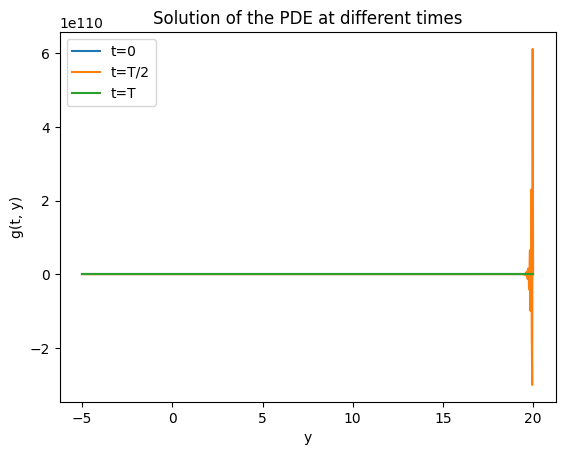

In [195]:
# Debugging: Plot the solution at different time steps
plt.plot(y_grid, g[:, 0], label='t=0')
plt.plot(y_grid, g[:, 251], label='t=T/2')
plt.plot(y_grid, g[:, -1], label='t=T')
plt.xlabel('y')
plt.ylabel('g(t, y)')
plt.title('Solution of the PDE at different times')
plt.legend()
plt.show()

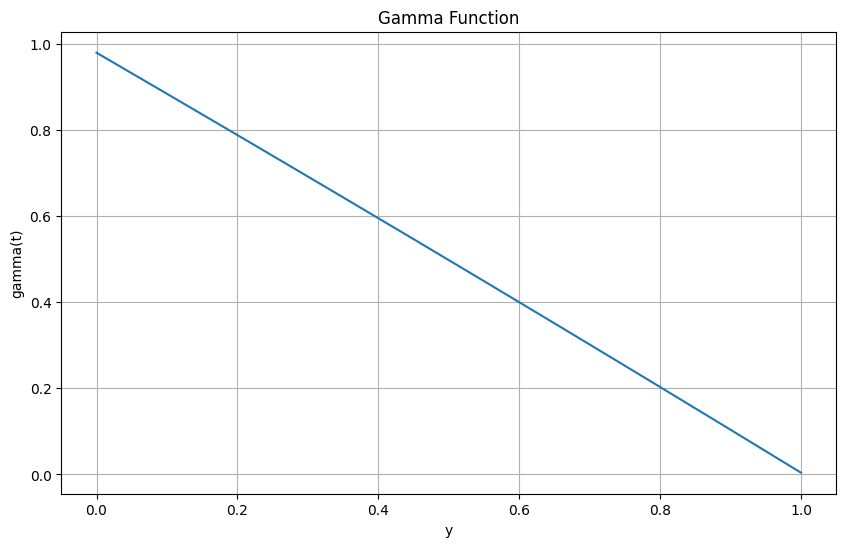

In [196]:
plt.figure(figsize=(10, 6))
plt.plot(time_grid, [gamma(j) for j in range(n_steps+1)])
plt.xlabel('y')
plt.ylabel('gamma(t)')
plt.title('Gamma Function')
plt.grid(True)
plt.show()

In [197]:
np.mean(np.exp(-r*(T-time_grid)))

0.9754123163440456

In [198]:
g

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -3.09589889e-070,  7.69207796e-074,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         6.09149235e-069,  4.45663661e-073,  0.00000000e+000],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -1.43030670e+112, -3.00407714e+110,  1.99500000e+001],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         2.90972119e+112,  6.11383712e+110,  1.99750000e+001],
       [ 2.00000000e+001,  2.00000000e+001,  2.00000000e+001, ...,
         2.00000000e+001,  2.00000000e+001,  2.00000000e+001]])

### Pricing

In [228]:
import QuantLib as ql
today = ql.Date().todaysDate()
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.05, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0., ql.Actual365Fixed()))
volatility = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), 0.2, ql.Actual365Fixed()))
initialValue = ql.QuoteHandle(ql.SimpleQuote(1))
process = ql.BlackScholesMertonProcess(initialValue, dividendTS, riskFreeTS, volatility)

tGrid, xGrid, aGrid = 252, 1000, 500
engine = ql.FdBlackScholesAsianEngine(process, tGrid=tGrid, xGrid=xGrid, aGrid=aGrid)

In [229]:
periods = [ql.Period("12M")]

pastFixings = 0 # Empty because this is a new contract
asianFutureFixingDates = [today + period for period in periods]
asianExpiryDate = today + periods[-1]
europeanExercise = ql.EuropeanExercise(asianExpiryDate)
arithmeticAverage = ql.Average().Arithmetic
arithmeticRunningAccumulator = 0.0

In [230]:
strike = 1.05
vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)
discreteArithmeticAsianOption = ql.DiscreteAveragingAsianOption(arithmeticAverage, arithmeticRunningAccumulator, pastFixings, asianFutureFixingDates, vanillaPayoff, europeanExercise)
discreteArithmeticAsianOption.setPricingEngine(engine)
print(discreteArithmeticAsianOption.NPV())

0.08021541999404501


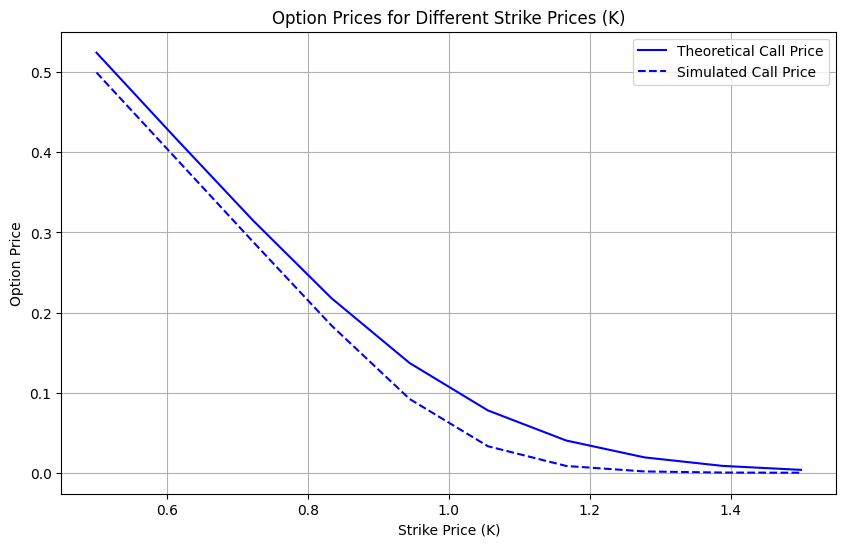

In [231]:
# Parameters
S0 = 1
r = 0.05
T = n_periods
t = 0
sigma = 0.2

# Define the functions for Asian call and put
asian_call = lambda x: np.maximum(x.mean(axis=1) - K, 0)
asian_put = lambda x: np.maximum(K - x.mean(axis=1), 0)

# K values to loop over (fine grid from 0.1 to 2.0)
K_values = np.linspace(0.5, 1.5, 10)

# Store results
exact_call_prices = []
# exact_put_prices = []
mc_call_ul_prices = []
# mc_put_ul_prices = []

gamma_t1 = np.mean(np.exp(-r*(T-paths_df.columns[1:])))
for K in K_values:
    vanillaPayoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
    discreteArithmeticAsianOption = ql.DiscreteAveragingAsianOption(arithmeticAverage, arithmeticRunningAccumulator, pastFixings, asianFutureFixingDates, vanillaPayoff, europeanExercise)
    discreteArithmeticAsianOption.setPricingEngine(engine)

    exact_call_price = discreteArithmeticAsianOption.NPV()
    # exact_put_price = K*np.exp(-r*(T-t)) - S0 + exact_call_price

    mc_call_ul_price = np.mean(np.exp(-r*(T-t))*asian_call(paths_df.iloc[:,1:]))
    # mc_put_ul_price = np.mean(np.exp(-r*(T-t))*asian_put(paths_df.iloc[:,1:]))

    exact_call_prices.append(exact_call_price)
    # exact_put_prices.append(exact_put_price)
    mc_call_ul_prices.append(mc_call_ul_price)
    # mc_put_ul_prices.append(mc_put_ul_price)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_values, exact_call_prices, 'b', label='Theoretical Call Price')
plt.plot(K_values, mc_call_ul_prices, 'b--', label='Simulated Call Price')
# plt.plot(K_values, exact_put_prices, 'r', label='Theoretical Put Price')
# plt.plot(K_values, mc_put_ul_prices, 'r--', label='Simulated Put Price')

plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.title('Option Prices for Different Strike Prices (K)')
plt.legend()
plt.grid(True)
plt.show()

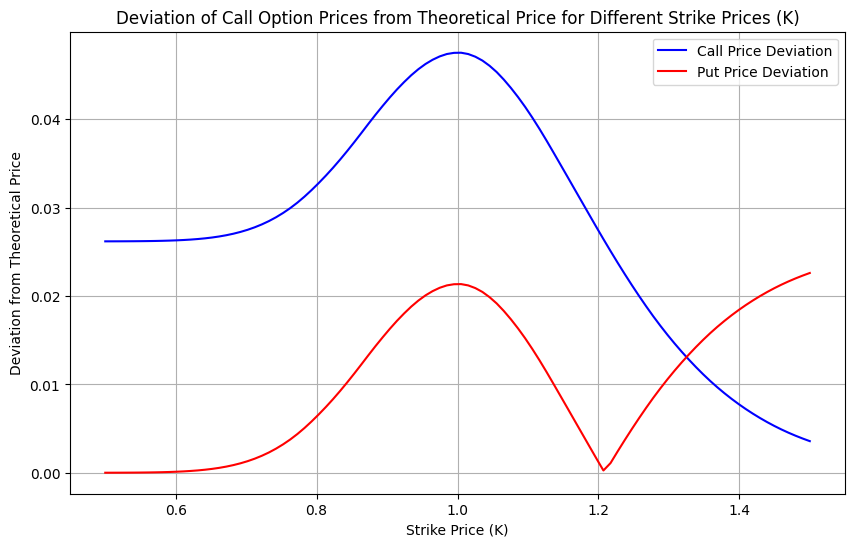

In [200]:
# K values to loop over (fine grid from 0.1 to 2.0)
K_values = np.linspace(0.5, 1.5, 100)

# Store results
ul_call_deviations = []
ul_put_deviations = []

for K in K_values:
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    exact_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    exact_put_price = K*np.exp(-r*(T-t)) - S0 + exact_call_price

    mc_call_ul_price = np.mean(np.exp(-r*(T-t))*asian_call(paths_df.iloc[:,1:]))
    mc_put_ul_price = np.mean(np.exp(-r*(T-t))*asian_put(paths_df.iloc[:,1:]))

    ul_call_deviations.append(abs(mc_call_ul_price - exact_call_price))
    ul_put_deviations.append(abs(mc_put_ul_price - exact_put_price))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_values, ul_call_deviations, 'b' ,label='Call Price Deviation')
plt.plot(K_values, ul_put_deviations, 'r',label='Put Price Deviation')

plt.xlabel('Strike Price (K)')
plt.ylabel('Deviation from Theoretical Price')
plt.title('Deviation of Call Option Prices from Theoretical Price for Different Strike Prices (K)')
plt.legend()
plt.grid(True)
plt.show()


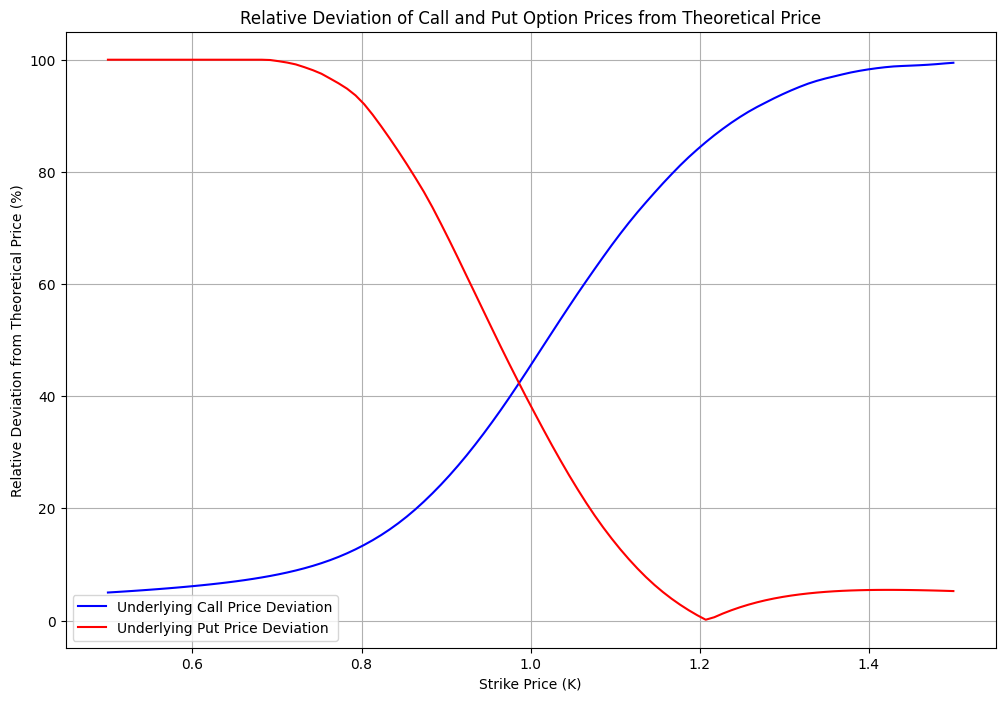

In [201]:
# K values to loop over
K_values = np.linspace(0.5, 1.5, 100)

# Store results
ul_call_deviations = []
ul_put_deviations = []

for K in K_values:
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    exact_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    exact_put_price = K*np.exp(-r*(T-t)) - S0 + exact_call_price

    mc_call_ul_price = np.mean(np.exp(-r*(T-t))*asian_call(paths_df.iloc[:,1:]))
    mc_put_ul_price = np.mean(np.exp(-r*(T-t))*asian_put(paths_df.iloc[:,1:]))

    ul_call_deviation = abs(mc_call_ul_price - exact_call_price) / exact_call_price * 100
    ul_put_deviation = abs(mc_put_ul_price - exact_put_price) / exact_put_price * 100

    ul_call_deviations.append(ul_call_deviation)
    ul_put_deviations.append(ul_put_deviation)

# Plot the results
plt.figure(figsize=(12, 8))

plt.plot(K_values, ul_call_deviations, 'b', label='Underlying Call Price Deviation')
plt.plot(K_values, ul_put_deviations, 'r', label='Underlying Put Price Deviation')

plt.xlabel('Strike Price (K)')
plt.ylabel('Relative Deviation from Theoretical Price (%)')
plt.title('Relative Deviation of Call and Put Option Prices from Theoretical Price')
plt.legend()
plt.grid(True)
plt.show()